In [1]:
# LangChain
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, SystemMessage, ToolMessage

# LangGraph
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver


# General
import ast
import operator
import datetime
from FastAPI_Helpers import prompts
from typing import TypedDict, Annotated
from IPython.display import Image, display

In [2]:
class AgentState(TypedDict):
  conversation: Annotated[list[AnyMessage], operator.add]

In [3]:
class Agent:
  def __init__(self, model, tools, system_prompt):

    self.model = model.bind_tools(tools)
    self.system_prompt = system_prompt
    self.tools = {tool.name: tool for tool in tools}

    memory = MemorySaver()

    graph = StateGraph(state_schema=AgentState)
    
    graph.add_node('LLM', self.use_model)
    graph.add_node('ToolBox', self.use_tools)

    graph.add_conditional_edges('LLM', self.validate_tools, {True:'ToolBox', False: END})
    graph.add_edge('ToolBox', 'LLM')
    graph.set_entry_point('LLM')

    self.graph = graph.compile(checkpointer=memory)
    display(Image(self.graph.get_graph().draw_mermaid_png()))
  
  ## Talk to the model
  def use_model(self, state: AgentState):

    messages = [SystemMessage(content=self.system_prompt)] + state['conversation']
    ai_response = self.model.invoke(messages)

    return {'conversation': [ai_response]}
  
  ## Checks if model wants to use tools
  def validate_tools(self, state: AgentState):
    if len(state['conversation'][-1].tool_calls) > 0:
      return True
    else:
      return False
  
  ## Checks if tools exist. If yes, uses them. Otherwise, tells the LLM to retry
  def use_tools(self, state: AgentState):
    
    tool_calls = state['conversation'][-1].tool_calls
    results = []
  
    for tool in tool_calls:
      # Use the tool
      if tool['name'] in self.tools:
        print(f"---- Calling: {tool['name']}")
        result = self.tools[tool['name']].invoke(tool['args'])

      # Tell the LLM to retry    
      else:
        print(f"---- Error, tool name not found: {tool['name']}")
        result = "tool name not found in list of tools. retry your tool use."

      # Save the returned output
      results.append(ToolMessage(name=tool['name'], tool_call_id=tool['id'], content=str(result)))

    return {'conversation': results}
  

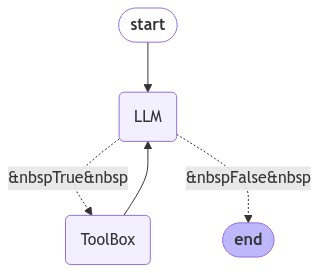

In [4]:
# model = ChatGroq(model="mixtral-8x7b-32768", temperature=0.2)
model = ChatGroq(model="llama3-70b-8192", temperature=0.2)

tavily_search_client = TavilySearchResults(max_results=5)

agent = Agent(model=model, tools=[tavily_search_client], system_prompt=prompts.searcher_prompt.format(todays_date=str(datetime.datetime.now().date())))

In [11]:
config = {"configurable": {"thread_id": "1"}}
response = []
for event in agent.graph.stream({"conversation": [HumanMessage(content=str("What were we talking about?"))]}, config, stream_mode="values"):
    response.append(event["conversation"][-1])

In [12]:
state = agent.graph.get_state(config=config).values
print(state['conversation'][-1].content)

We were discussing psychology fields that are in high demand. I provided some initial information on three fields: Vocational/Career Counselor, Psychologists in Equity, Diversity, and Inclusion (EDI) roles, and Sport Psychology. You then asked me to explain each of these fields in more detail, and I started by providing more information on Vocational/Career Counselors using a tool to gather relevant information.
